# Product Recognition of Food Products
 Image Processing and Computer Vision project
 
Habib Kazemi  0001119071 [habib.kazemi2@studio.unibo.it]

Safoura Banihashemi 0001109509 [safoura.banihashemi@studio.unibo.it]

Hesam Sheikh Hassani 0001111590 [hesam.sheikhhassani@studio.unibo.it]

 



## Track B - Multiple Instances Detection

In this track, there might be multiple instances of a product in the scene, and we need to identify them all. The main challenges of this track are the heavy noise and the presence of very similar products where the primary difference is their color. Since SIFT (Scale-Invariant Feature Transform) is designed primarily for grayscale images, distinguishing between these similar products poses a significant challenge. To address this, we incorporate verifiers to remove false positives.

### Verifiers:
1. **similar_based_on_BGR_sift**:
    - Calculates keypoints and descriptions on each color channel (B, G, R).
    - The sum of the number of good matches across all channels should be above a set threshold to confirm a match.

2. **similar_based_on_color**:
    - Converts images into the HSV color space to separate image luminance from color information.
    - Divides the images into bins and compares the mean H (Hue) and S (Saturation) values of the bins between two images.
    - If a specific number of bins exceed a threshold difference, the images are considered to have dissimilar colors.

This approach helps in differentiating between products based on color variations, thus improving the accuracy of multiple instance detection.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/AssignmentsIPCV/dataset.zip ./
!unzip dataset.zip

## Import Libraries

In [1]:
# Import library
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

## Loading reference and scene images

In [2]:
def load_images_from_directory(directory, file_name_list):
    """
    Load images from a directory and store them in a dictionary.

    Args:
        directory (str): The directory path where the images are located.
        file_name_list (list): A list of file names of the images to be loaded.

    Returns:
        dict: A dictionary where the keys are the file names and the values are the loaded images.

    """
    images = {}
    for file_name in file_name_list:
        image_path = os.path.join(directory, file_name)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        images[file_name] = image
    return images


In [3]:
models_dir = "dataset/models"
scenes_dir = "dataset/scenes"

trackB_scene_images_file_names = [f'scene{i}.png' for i in range(6, 13)]
trackB_reference_images_file_names = [f'ref{i}.png' for i in range(15, 28)]

trackB_scene_images = load_images_from_directory(scenes_dir, trackB_scene_images_file_names)
trackB_reference_images = load_images_from_directory(models_dir, trackB_reference_images_file_names)

print(trackB_scene_images.keys())
print(trackB_reference_images.keys())

dict_keys(['scene6.png', 'scene7.png', 'scene8.png', 'scene9.png', 'scene10.png', 'scene11.png', 'scene12.png'])
dict_keys(['ref15.png', 'ref16.png', 'ref17.png', 'ref18.png', 'ref19.png', 'ref20.png', 'ref21.png', 'ref22.png', 'ref23.png', 'ref24.png', 'ref25.png', 'ref26.png', 'ref27.png'])


## Denoise images
Images have heavy noise and need to denoise them before extracting features.

In [4]:
def denoise_image(img):
    """
    Applies denoising to the input image.

    Parameters:
    img (numpy.ndarray): The input image to be denoised.

    Returns:
    numpy.ndarray: The denoised image.
    """
    median_blurred = cv2.medianBlur(img, 5)
    return cv2.bilateralFilter(median_blurred, 9, 75, 75)

In [5]:
trackB_denoised_scene_images = {}
for filename, image in trackB_scene_images.items():
    trackB_denoised_scene_images[filename] = denoise_image(image)

## Keypoint detection and description
We used SIFT (Scale-Invariant Feature Transform) to detect keypoint and extract descriptions from the images. To match these descriptions, we employed a brute-force matcher.

In [6]:
def extract_features_sift(image):
    """
    Extracts SIFT features from the given image.

    Parameters:
    image (numpy.ndarray): The input image.

    Returns:
    keypoints (list): List of keypoints detected in the image.
    descriptions (numpy.ndarray): Array of descriptions computed for each keypoint.
    """
    sift = cv2.SIFT_create()
    keypoints, descriptions = sift.detectAndCompute(image, None)
    return keypoints, descriptions


def match_descriptions(ref_descriptions, scene_descriptions, ratio=0.75):
    """
    Matches the reference descriptions with the scene descriptions.
    It applys lowe's ratio test to filter the good matches.

    Parameters:
    ref_descriptions (list): List of reference descriptions.
    scene_descriptions (list): List of scene descriptions.
    ratio (float): Ratio threshold for the ratio test. Default is 0.75.

    Returns:
    list: List of good matches.

    """
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(ref_descriptions, scene_descriptions, k=2)
    good_matches = [m for m, n in matches if m.distance < ratio * n.distance]
    return good_matches

## Helper functions to visualize keypoints and matches
Visualizing the results is crucial for understanding the project and debugging the code effectively.

In [7]:
def visualize_keypoints(ref_img, scene_img, ref_keypoints, scene_keypoints):
    """
    Visualizes the keypoints on the reference and scene images.

    Args:
        - ref_img (numpy.ndarray): The reference image.
        - scene_img (numpy.ndarray): The scene image.
        - ref_keypoints (list): List of keypoints detected in the reference image.
        - scene_keypoints (list): List of keypoints detected in the scene image.
    """
    # Draw keypoints on the reference and scene images
    ref_img_with_keypoints = cv2.drawKeypoints(ref_img, ref_keypoints, None, color=(0, 255, 0))
    scene_img_with_keypoints = cv2.drawKeypoints(scene_img, scene_keypoints, None, color=(0, 255, 0))

    # Display the images with keypoints
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Reference Image Keypoints')
    plt.imshow(cv2.cvtColor(ref_img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title('Scene Image Keypoints')
    plt.imshow(cv2.cvtColor(scene_img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
def visualize_keypoints_match(good_matches, inlier_match_title, ref_img, ref_keypoints, scene_img, scene_keypoints, mask=None):
    """
    Visualizes the keypoints match between two images.

    Args:
        good_matches (list): List of good matches between keypoints.
        inlier_match_title (str): Title for the visualization.
        ref_img (numpy.ndarray): Reference image.
        ref_keypoints (list): Keypoints in the reference image.
        scene_img (numpy.ndarray): Scene image.
        scene_keypoints (list): Keypoints in the scene image.
        mask (numpy.ndarray, optional): Homography Mask to filter the matches. Defaults to None.
    """
    draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                       singlePointColor=None,
                       flags=2)
    if mask is not None:
        draw_params['matchesMask'] = mask.ravel().tolist()
    img3 = cv2.drawMatches(ref_img, ref_keypoints, scene_img, scene_keypoints, good_matches, None, **draw_params)

    plt.figure(figsize=(15, 10))
    plt.title(inlier_match_title)
    plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    plt.show()


# Helper functions

In [9]:
def crop_image(img, dst):
    """
    Crop the input image based on the given corners.

    Parameters:
    img (numpy.ndarray): The input image to be cropped.
    dst (numpy.ndarray): The corners of the region to be cropped, obtained using perspectiveTransform.

    Returns:
    numpy.ndarray: The cropped image.

    """
    x, y, w, h = cv2.boundingRect(np.int32(dst))
    return img[y:y+h, x:x+w]

In [10]:
def remove_patch_from_image(img, rect):
    """
    Remove the detected patch from the image.

    Parameters:
    img (numpy.ndarray): The input image.
    dst (numpy.ndarray): The corners of the region to be removed, obtained using perspectiveTransform.

    Returns:
    numpy.ndarray: The image with the detected patch removed.

    """
    img2 = img.copy()
    x, y, w, h = rect
    img2[y:y+h, x:x+w] = 0
    return img2
    

# Calculate Homography

In [11]:
def calculate_homography(good_matches, projection_threshold, ref_keypoints, scene_keypoints):
    """
    Calculates the homography matrix and mask.

    Args:
        good_matches (list): List of good matches between reference and scene keypoints.
        projection_threshold (float): Threshold value for RANSAC algorithm.
        ref_keypoints (list): List of reference keypoints.
        scene_keypoints (list): List of scene keypoints.

    Returns:
        tuple: A tuple containing the homography matrix (M) and the mask.

    """
    # Extract location of good matches
    src_pts = np.float32([ref_keypoints[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dst_pts = np.float32([scene_keypoints[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)
    # Compute Homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, projection_threshold)
    return M, mask

## Clip coordinates
Found corners in the scene images might be out of the image bounds. To address this issue, we clip the coordinates to ensure they are within the image bounds.

In [12]:
def clip_coordinates(dst, image_width, image_height):
    """
    Clips the coordinates of the given corners to ensure they are within the image boundaries.

    Parameters:
    - dst (numpy.ndarray): The destination array containing the coordinates.
    - image_width (int): The width of the image.
    - image_height (int): The height of the image.

    Returns:
    - numpy.ndarray: The clipped corners array with coordinates within the image boundaries.
    """
    clipped_dst = np.copy(dst)
    clipped_dst[:, :, 0] = np.clip(dst[:, :, 0], 0, image_width - 1)
    clipped_dst[:, :, 1] = np.clip(dst[:, :, 1], 0, image_height - 1)
    return clipped_dst

# Verifiers
### Color Verifiers



#### Verifier to compare colors of bins
- The scene images have heavy noise, and to check the color similarity, we apply a more intensive denoising process using `cv2.ximgproc.createAMFilter`. This denoising will remove some details, but since this is a verifier to compare colors, the loss of detail is not important. 
- Converts images into the HSV color space to separate image luminance from color information.
- Divides the images into bins and compares the mean H (Hue) and S (Saturation) values of the bins between two images.
- If a specific number of bins exceed a threshold difference, the images are considered to have dissimilar colors.


This filter requires `opencv-contrib-python`.


In [13]:
def denoise_with_adaptive_manifold_filter(src, sigma_s=30, sigma_r=0.2):
    """
    Applies the adaptive manifold filter to denoise the input image.

    Parameters:
    - src: The input image to be denoised.
    - sigma_s: The spatial standard deviation for the adaptive manifold filter. Higher values preserve more details but may introduce more noise.
    - sigma_r: The range standard deviation for the adaptive manifold filter. Higher values increase the filter's range of influence.

    Returns:
    - numpy.ndarray: The denoised image after applying the adaptive manifold filter.
    """
    am_filter = cv2.ximgproc.createAMFilter(sigma_s, sigma_r, False)

    # Apply the filter
    median_blur = cv2.medianBlur(src, 3)
    am_filter_result = am_filter.filter(median_blur)

    return am_filter_result


In [14]:
def split_and_calculate_channel_mean_for_bins(image, n_bins_width=3, n_bins_height=4):
    """
    Splits an image into bins and calculates the mean color channels for each bin.

    Args:
        image (numpy.ndarray): The input image.
        n_bins_width (int): The number of bins in the horizontal direction. Default is 3.
        n_bins_height (int): The number of bins in the vertical direction. Default is 4.

    Returns:
        dict: A dictionary containing the mean color channels for each bin. The keys are tuples
        representing the bin coordinates (row, column), and the values are tuples containing the
        mean values for the channels.
    """

    bins = {}

    img_height, img_width = image.shape[:2]

    if img_height == 0 or img_width == 0 or n_bins_width == 0 or n_bins_height == 0:
        return bins

    step_width = img_width // n_bins_width
    step_height = img_height // n_bins_height

    for r in range(n_bins_height):
        for c in range(n_bins_width):
            start_row = r * step_height
            end_row = min((r + 1) * step_height, img_height)
            start_col = c * step_width
            end_col = min((c + 1) * step_width, img_width)

            # Handle edge case for the last row and column
            if r == n_bins_height - 1:
                end_row = img_height
            if c == n_bins_width - 1:
                end_col = img_width

            bin_section = image[start_row:end_row, start_col:end_col]
            mean_channels = cv2.mean(bin_section)[:3]  # Get means of the 3 color channels

            bins[(r, c)] = mean_channels

    return bins


In [15]:
def hsv_images_similar(ref_img, patch_img, w_bin_number=3, h_bin_number=4, each_channel_color_diff_th=40, max_diff_bins_th=2, debug=False):
    """
    Check if two images are similar based on their HSV color channels.

    Args:
        ref_img (numpy.ndarray): The reference image.
        patch_img (numpy.ndarray): The patch image to compare with the reference image.
        w_bin_number (int, optional): The number of bins for the width dimension. Defaults to 3.
        h_bin_number (int, optional): The number of bins for the height dimension. Defaults to 4.
        each_channel_color_diff_th (int, optional): The threshold for color difference in each channel. Defaults to 40.
        max_diff_bins_th (int, optional): The maximum number of different bins allowed. Defaults to 2.
        debug (bool, optional): Whether to print debug information. Defaults to False.

    Returns:
        bool: True if the images are similar, False otherwise.
    """
    above_th_count = 0

    ref_img_mean_hsv_bins = split_and_calculate_channel_mean_for_bins(ref_img, w_bin_number, h_bin_number)

    patch_img_hsv_mean_bins = split_and_calculate_channel_mean_for_bins(patch_img, w_bin_number, h_bin_number)

    if not patch_img_hsv_mean_bins or not patch_img_hsv_mean_bins:
        return []

    for k, v in ref_img_mean_hsv_bins.items():
        means_k_scene = patch_img_hsv_mean_bins.get(k)
        diff_h_channel = np.absolute(v[0] - means_k_scene[0])
        diff_s_channel = np.absolute(v[1] - means_k_scene[1])

        if debug:
            print('Bin ({}, {}):'.format(k[0], k[1]))
            print('  - diff_h: ', diff_h_channel)
            print('  - diff_s: ', diff_s_channel)

        if diff_h_channel >= each_channel_color_diff_th:
            above_th_count += 1
        if diff_s_channel >= each_channel_color_diff_th:
            above_th_count += 1

    if above_th_count >= max_diff_bins_th:
        return False    
    return True


In [16]:
def similar_based_on_color(ref_img, patch_img, w_bin_number=3, h_bin_number=4, debug=False):
    """
    Check whether the patch image is similar to the reference image based on color.
    This comparison uses the HSV color space to separate luminance from color information.
    It compares the color channels of the images within different bins.


    Args:
        ref_img (numpy.ndarray): The reference image(BGR).
        patch_img (numpy.ndarray): The patch image(BGR).
        w_bin_number (int, optional): The number of divisions along the x-axis. Defaults to 3.
        h_bin_number (int, optional): The number of divisions along the y-axis. Defaults to 4.
        debug (bool, optional): Whether to display debug information. Defaults to False.

    Returns:
        bool: True if the images are similar based on color, False otherwise.

    """
    # First we need to do a heavier denoising, we do not care if remove edges and corners in this validation
    denoised_patch_img = denoise_with_adaptive_manifold_filter(patch_img)
    # we should convert them to hsv, as hsv has properties that are similar to human perception
    # and much better for this task
    ref_img_hsv = cv2.cvtColor(ref_img, cv2.COLOR_BGR2HSV)
    denoised_patch_img_hsv = cv2.cvtColor(denoised_patch_img, cv2.COLOR_BGR2HSV)
    if debug:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        ax[0].imshow(cv2.cvtColor(patch_img, cv2.COLOR_BGR2RGB), extent=[0, 2, 0, 3])
        ax[1].imshow(cv2.cvtColor(ref_img, cv2.COLOR_BGR2RGB), extent=[0, 2, 0, 3])


        # Draw horizontal and vertical lines to divide the image into 3*4 parts
        num_divisions_x = w_bin_number  # Number of divisions along x-axis
        num_divisions_y = h_bin_number # Number of divisions along y-axis

        # Draw vertical lines
        for i in range(1, num_divisions_x):
            x = 2 * i / num_divisions_x
            ax[0].axvline(x, color='black', linestyle='--')

        # Draw horizontal lines
        for i in range(1, num_divisions_y):
            y = 3 * i / num_divisions_y
            ax[0].axhline(y, color='black', linestyle='--')

        # Draw vertical lines
        for i in range(1, num_divisions_x):
            x = 2 * i / num_divisions_x
            ax[1].axvline(x, color='black', linestyle='--')

        # Draw horizontal lines
        for i in range(1, num_divisions_y):
            y = 3 * i / num_divisions_y
            ax[1].axhline(y, color='black', linestyle='--')
        ax[0].set_title('Patch Image: ')
        ax[1].set_title('Ref Image ')
        plt.show()

    return hsv_images_similar(ref_img_hsv, denoised_patch_img_hsv, w_bin_number, h_bin_number, each_channel_color_diff_th=40, max_diff_bins_th=2, debug=debug)


### Verifier to match descriptions on each channel:

   - Calculates keypoints and descriptions on each color channel (R, G, B).
   - The sum of the number of good matches across all channels should be above a set threshold to confirm a match.

In [17]:
def extract_features_sift_BGR(image):
    """
    Extracts SIFT keypoints and descriptions for each channel of the input BGR image.

    Parameters:
    image (numpy.ndarray): The input BGR image.

    Returns:
    tuple: A tuple containing two lists - keypoints and descriptions.
           - keypoints (list): A list of keypoints lists for each channel.
           - descriptions (list): A list of coressponding descriptions lists for each channel.

    """
    keypoints = []
    descriptions = []
    for c in range(3):
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(image[:,:,c], None)
        keypoints.append(kp)
        descriptions.append(des)

    return keypoints, descriptions

In [18]:
def match_descriptions_BGR(ref_descriptions, scene_descriptions, ratio=0.75):
    """
    Matches descriptions generated for each channel between reference and scene images.

    Parameters:
    - ref_descriptions (list): List of reference image descriptions for each channel (B, G, R).
    - scene_descriptions (list): List of scene image descriptions for each channel (B, G, R).
    - ratio (float): Ratio threshold for matching distance.

    Returns:
    - good_matches (list): List of good matches lists for each channel.

    """
    good_matches = []
    for c in range(3):
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(ref_descriptions[c], scene_descriptions[c], k=2)
        channel_good_matches = [m for m, n in matches if m.distance < ratio * n.distance]
        good_matches.append(channel_good_matches)
    return good_matches


In [19]:
def similar_based_on_BGR_sift(ref_img, scene_img, threshold=95, debug=False):
    """
    Determines if two images are similar based on their BGR SIFT features.

    Parameters:
    - ref_img (numpy.ndarray): The reference image.
    - scene_img (numpy.ndarray): The scene image to compare with the reference image.
    - threshold (int, optional): The minimum number of matches required to consider the images similar. Default is 95.
    - debug (bool, optional): Whether to enable debug mode. If True, additional information will be printed. Default is False.

    Returns:
    - bool: True if the images are similar, False otherwise.
    """
    scene_img = cv2.medianBlur(scene_img, 5)
    ref_keypoints, ref_descriptions = extract_features_sift_BGR(ref_img)
    scene_keypoints, scene_descriptions = extract_features_sift_BGR(scene_img)
    
    #flatten ref_keypoints and scene_keypoints
    f_ref_keypoints = [kp for sublist in ref_keypoints for kp in sublist]
    f_scene_keypoints = [kp for sublist in scene_keypoints for kp in sublist]
    
    if debug:
        visualize_keypoints(ref_img, scene_img, f_ref_keypoints, f_scene_keypoints)
        
    good_matches = match_descriptions_BGR(ref_descriptions, scene_descriptions, ratio=0.75)
    
    _sum = 0
    for gm in good_matches:
        if debug:
            print(f"Good matches: , {len(gm)}")
        _sum += len(gm)
    if debug:
        print(_sum)
    return _sum >= threshold 
    

### non-color verifiers
#### Aspect Ratio Verifier
* This verifier is not for color similarity. This verifier compares the aspect ratio of the product found in the scene and the reference image. They should not be very different.


In [20]:
def have_similar_aspect_ratio(ref_img, patch_img, debug=False):
    """
    Check if the aspect ratio of the patch image is similar to the aspect ratio of the reference image.

    Parameters:
    ref_img (numpy.ndarray): The reference image.
    patch_img (numpy.ndarray): The patch image to compare.
    debug (bool, optional): If True, print debug information. Default is False.

    Returns:
    bool: True if the aspect ratio is similar, False otherwise.
    """
    ref_h, ref_w = ref_img.shape[:2]
    h, w = patch_img.shape[:2]
    ref_aspect_ratio = ref_w / ref_h
    aspect_ratio = w / h
    if debug:
        print("ref_aspect_ratio:", ref_aspect_ratio)
        print("rect aspect ratio:", aspect_ratio)
    if abs(aspect_ratio - ref_aspect_ratio) < 0.1:
        if debug:
            print("Aspect ratio is similar")
        return True
    if debug:
        print("Aspect ratio is not similar")
    return False


## Find Multiple Instances in the Scene Images

This function identifies instances of the reference images within the scene images. It first calculates the homography between the reference and scene images using the good matches and then projects the corners into the scenes using `perspectiveTransform` to locate an area that potentially contains an instance. This area is then cropped, and several verifiers are applied to confirm whether it is the instance we are looking for.

### Verifiers:
1. **Size Check**: Verifies the size of the area claimed to be an instance. If it is too small, it is not considered an instance.
2. **Aspect Ratio Comparison**: Compares the aspect ratio of the reference and the detected object. They should not differ significantly.
3. **Color Comparison using BGR SIFT**: Compares the colors using BGR SIFT.
4. **Color Comparison using Mean of Bins**: Compares the colors by analyzing the mean values of the color bins.



In [21]:
def find_multi_instance_in_image(ref_img, scene_img, ref_keypoints, scene_keypoints, good_matches, inlier_match_title ='Inlier Matches', projection_threshold=5.0, inlier_threshold=55, debug=False):
    """
    Finds multiple instances of a reference image in a scene image using homography and various validations.

    Args:
        ref_img (numpy.ndarray): The reference image.
        scene_img (numpy.ndarray): The scene image.
        ref_keypoints (list): List of keypoints in the reference image.
        scene_keypoints (list): List of keypoints in the scene image.
        good_matches (list): List of good matches between keypoints in the reference and scene images.
        inlier_match_title (str, optional): Title for the visualization of inlier matches. Defaults to 'Inlier Matches'.
        projection_threshold (float, optional): Threshold for homography calculation. Defaults to 5.0.
        inlier_threshold (int, optional): Threshold for the number of inliers. Defaults to 55.
        debug (bool, optional): Flag to enable debug mode. Defaults to False.

    Returns:
        tuple: A tuple containing a boolean indicating if the instances were found, and the bounding rectangle of the instances.
    """
    # #flatten
    # good_matches = [m for sublist in good_matches for m in sublist]
    # ref_keypoints = [kp for sublist in ref_keypoints for kp in sublist]
    # scene_keypoints = [kp for sublist in scene_keypoints for kp in sublist]
    M, mask = calculate_homography(good_matches, projection_threshold, ref_keypoints, scene_keypoints)

    num_of_inliers = sum(mask.ravel())
    if debug: print("num_of_inliers: ", num_of_inliers)

    ref_h, ref_w = ref_img.shape[:2]
    # Corners of the reference image
    pts = np.float32([[0,0], [0, ref_h - 1], [ref_w - 1, ref_h - 1], [ref_w - 1, 0]]).reshape(-1, 1, 2)

    # Projecting the corners into the Scene image
    try:
        dst = cv2.perspectiveTransform(pts, M)
    except:
        return False, (0,0,0,0)

    # Ensure dst coordinates are within image bounds
    dst = clip_coordinates(dst, scene_img.shape[1], scene_img.shape[0])

    cropped_img = crop_image(scene_img, dst)
    cropped_w, cropped_h = cropped_img.shape[:2]
    if debug:
        visualize_keypoints_match(good_matches, inlier_match_title, ref_img, ref_keypoints, scene_img, scene_keypoints)
        draw_bounding_box_with_label('DEBUG Bounding Box for Scene', {'D': [cv2.boundingRect(dst)]}, scene_img.copy())
        print("Cropped image size: ", cropped_img.shape[:2])
    
    # let's do some validations 
    confidence = 0
    same_color = False
    if cropped_w > 50 and cropped_h > 50:
        # We will do some validations to know if we had find the correct object
        # first let's check if the aspect ratio is similar
        if not have_similar_aspect_ratio(trackB_reference_images[ref_name], cropped_img, debug):
            return False, (0,0,0,0)
        
        if not similar_based_on_BGR_sift(ref_img, cropped_img, threshold=95, debug=debug):
            return False, (0,0,0,0)
            
        # Let's check if the products have similar colors
        same_color = similar_based_on_color(ref_img, cropped_img, debug=debug)
        if debug:
            print("Same color: ", same_color)
            print("Similarity confidence: ", confidence)
        if not debug and not same_color:
            return False, (0,0,0,0)
        
    else:
        if debug:
            print("Crop size is too small", cropped_img.shape)
        return False, (0,0,0,0)


    return True, cv2.boundingRect(dst)


## Draw boundings and add labels
To visualize the bounding boxes, we draw rectangles around the detected instances. We also add labels to the bounding boxes to indicate the reference image that was found in the scene image.

In [22]:
def draw_bounding_box_with_label(bounding_box_title, rect_dict, img):
    """
    Draw bounding boxes with labels on an image.

    Parameters:
    - bounding_box_title (str): The title of the bounding box plot.
    - rect_dict (dict): A dictionary containing the labels as keys and a list of bounding box coordinates as values.
    - img (numpy.ndarray): The input image.

    Returns:
    None
    """

    colors = [
        [255, 0, 0],     # Red
        [0, 255, 0],     # Green
        [0, 0, 255],     # Blue
        [255, 165, 0],   # Orange
        [128, 0, 128],   # Purple
        [255, 255, 0],   # Yellow
        [0, 255, 255],   # Cyan
        [255, 0, 255],   # Magenta
        [0, 128, 0],     # Dark Green
        [128, 128, 0]    # Olive 
    ]

    for i, (label, rect_list) in enumerate(rect_dict.items()):
        for (x, y, w, h) in rect_list:
            # Draw the bounding rectangle
            cv2.rectangle(img, (x, y), (x + w, y + h), colors[i], max(15 - i,5))

            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 2
            font_color = (255, 255, 255)  # white color
            thickness = 2
            text_size, _ = cv2.getTextSize(label, font, font_scale, thickness)

            # Draw a filled rectangle behind the text
            rectangle_bgr = colors[i]
            label_x, label_y = x+20, y + h -20 - i*text_size[0] // 2 # to prevent overlapping of labels we will shift the labels up according to i
            rectangle_x, rectangle_y = label_x - 5, label_y - text_size[1] - 5  # padding around text
            rectangle_w, rectangle_h = text_size[0] + 10, text_size[1] + 10  # padding around text
            cv2.rectangle(img, (rectangle_x, rectangle_y), (rectangle_x + rectangle_w, rectangle_y + rectangle_h), rectangle_bgr, -1)

            # Draw the text on top of the background rectangle
            cv2.putText(img, label, (label_x, label_y), font, font_scale, font_color, thickness, cv2.LINE_AA)

    plt.title(bounding_box_title)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()


## Extract features
We find keypoints and calculate descriptions for all reference and scene images of TrackB.

In [23]:
# Extract features for all reference and scene images of TrackB
trackB_scene_points = {}
trackB_ref_points = {}
for scene_name, scene_img in trackB_denoised_scene_images.items():
    ref_keypoints, ref_descriptions = extract_features_sift(scene_img)
    # ref_keypoints, ref_descriptions = hsv_sift_2(scene_img)
    trackB_scene_points[scene_name] = {'kp':ref_keypoints, 'desc':ref_descriptions}

for ref_name, ref_img in trackB_reference_images.items():
    ref_keypoints, ref_descriptions = extract_features_sift(ref_img)
    # ref_keypoints, ref_descriptions = hsv_sift_2(ref_img)
    trackB_ref_points[ref_name] = {'kp':ref_keypoints, 'desc':ref_descriptions}

## Complete the object detection

Here, we complete the object detection by finding instances of the reference images within the scene images. The process begins by matching the descriptions of the reference and scene images. If the number of good matches exceeds a predefined threshold, we invoke the `find_multi_instance_in_image` function. If an instance is found, it is removed from the scene, and the process is repeated until no more instances are detected. Finally, we draw a bounding box around each detected instance, add a label to the bounding box, and print the position, width, and height of the detected instance.


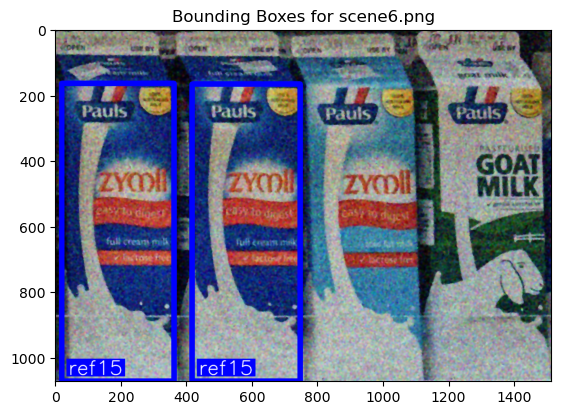

product ref15 - 2 instance found: 
	Instance 1 {position: (583, 619), width: 330px, height: 905px}
	Instance 2 {position: (191, 618), width: 343px, height: 907px}


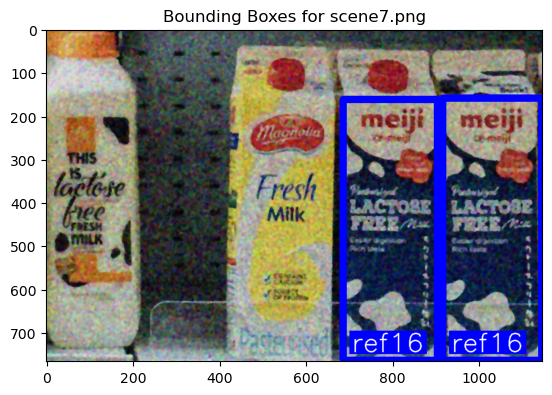

product ref16 - 2 instance found: 
	Instance 1 {position: (1030, 461), width: 229px, height: 605px}
	Instance 2 {position: (795, 463), width: 218px, height: 602px}


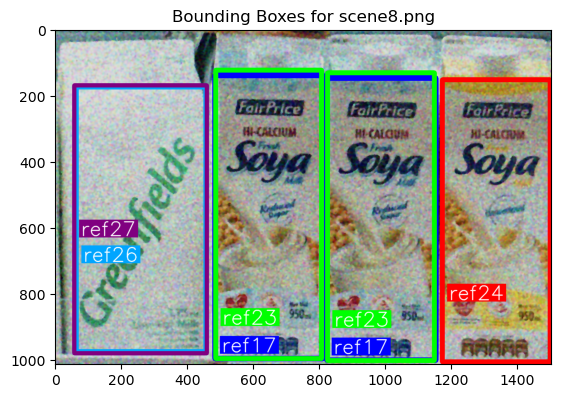

product ref17 - 2 instance found: 
	Instance 1 {position: (648, 568), width: 327px, height: 857px}
	Instance 2 {position: (989, 575), width: 330px, height: 854px}
product ref23 - 2 instance found: 
	Instance 1 {position: (988, 567), width: 324px, height: 871px}
	Instance 2 {position: (647, 560), width: 321px, height: 873px}
product ref24 - 1 instance found: 
	Instance 1 {position: (1337, 580), width: 327px, height: 854px}
product ref26 - 1 instance found: 
	Instance 1 {position: (260, 575), width: 391px, height: 799px}
product ref27 - 1 instance found: 
	Instance 1 {position: (259, 575), width: 402px, height: 811px}


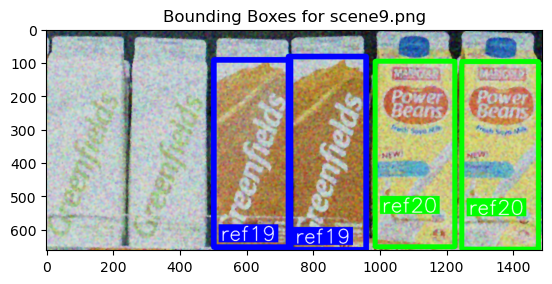

product ref19 - 2 instance found: 
	Instance 1 {position: (843, 371), width: 233px, height: 579px}
	Instance 2 {position: (618, 372), width: 230px, height: 561px}
product ref20 - 2 instance found: 
	Instance 1 {position: (1106, 374), width: 239px, height: 556px}
	Instance 2 {position: (1362, 378), width: 230px, height: 562px}


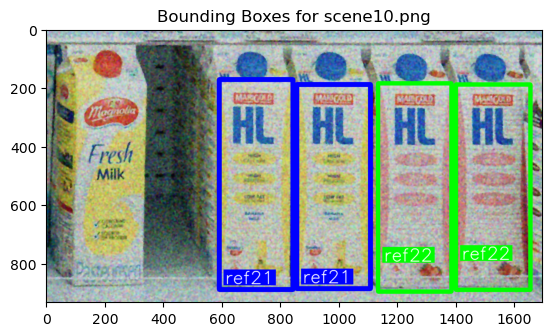

product ref21 - 2 instance found: 
	Instance 1 {position: (983, 537), width: 252px, height: 697px}
	Instance 2 {position: (718, 530), width: 252px, height: 717px}
product ref22 - 2 instance found: 
	Instance 1 {position: (1260, 540), width: 251px, height: 711px}
	Instance 2 {position: (1528, 539), width: 255px, height: 701px}


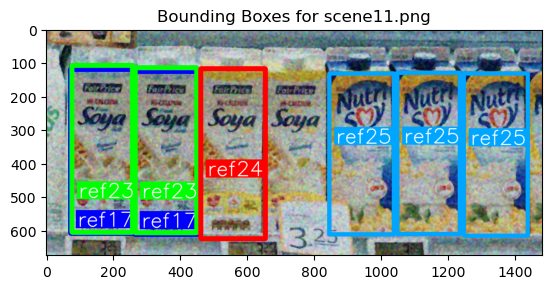

product ref17 - 2 instance found: 
	Instance 1 {position: (167, 363), width: 186px, height: 489px}
	Instance 2 {position: (361, 368), width: 192px, height: 486px}
product ref23 - 2 instance found: 
	Instance 1 {position: (167, 357), width: 181px, height: 498px}
	Instance 2 {position: (358, 361), width: 184px, height: 492px}
product ref24 - 1 instance found: 
	Instance 1 {position: (558, 371), width: 193px, height: 507px}
product ref25 - 3 instance found: 
	Instance 1 {position: (1343, 374), width: 191px, height: 484px}
	Instance 2 {position: (942, 372), width: 193px, height: 480px}
	Instance 3 {position: (1142, 370), width: 187px, height: 481px}


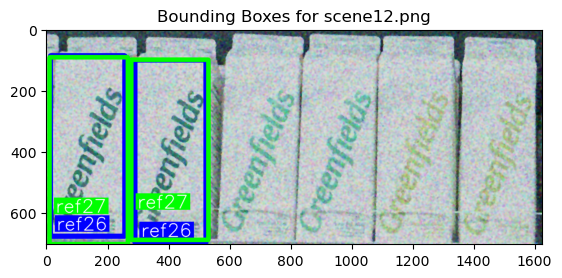

product ref26 - 2 instance found: 
	Instance 1 {position: (136, 382), width: 244px, height: 591px}
	Instance 2 {position: (407, 400), width: 233px, height: 598px}
product ref27 - 2 instance found: 
	Instance 1 {position: (139, 398), width: 257px, height: 612px}
	Instance 2 {position: (405, 395), width: 253px, height: 590px}


In [24]:
min_match_count = 20
debug = False
found_items = {}
for scene_name, scene_data in trackB_scene_points.items():
    found_items[scene_name] = {}
    for ref_name, ref_data in trackB_ref_points.items():
        scene_copy = trackB_denoised_scene_images[scene_name].copy()
        repeat = True
        while repeat:
            scene_kp_desc = extract_features_sift(scene_copy)
            good_matches = match_descriptions(ref_data['desc'], scene_kp_desc[1])
            if debug:
                print(f"Number of good matches between {ref_name} and {scene_name}: {len(good_matches)}")
            if len(good_matches) > min_match_count:
                found, bounding_rect = find_multi_instance_in_image(trackB_reference_images[ref_name], scene_copy, ref_data['kp'], scene_kp_desc[0], good_matches, inlier_match_title=f'Inlier Matches Between {ref_name} and {scene_name}', debug=debug)
                if found:
                    scene_copy = remove_patch_from_image(scene_copy, bounding_rect)
                    label = ref_name.replace(".png", "")
                    if label in found_items[scene_name]:
                        found_items[scene_name][label].append(bounding_rect)
                    else:
                        found_items[scene_name][label] = [bounding_rect]
                else:
                    repeat = False
            else:
                repeat = False
    
    draw_bounding_box_with_label(f'Bounding Boxes for {scene_name}', found_items[scene_name], trackB_denoised_scene_images[scene_name].copy())
    for (ref_name, rect_list) in found_items[scene_name].items():
        print(f"product {ref_name} - {len(found_items[scene_name][ref_name])} instance found: ")
        for i, (x, y, w, h) in enumerate(rect_list):
            print(f"\tInstance {i+1} {{position: ({x + w // 2}, {y + h // 2}), width: {w}px, height: {h}px}}")
            
            